# 1. Preparación de datos: División train/test.

In [1]:
# Importar las librerías necesarias para la carga y preparación inicial

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy  as np  
import matplotlib.pyplot as plt
%matplotlib inline

# Cargar el conjunto de datos
data_path = './airbnb-listings.csv'
airbnb_data = pd.read_csv(data_path, delimiter=';', on_bad_lines='skip')

# Eliminar la columna 'Picture Url' del conjunto de datos
airbnb_data = airbnb_data.drop(columns=['Picture Url'], errors='ignore')


# División del conjunto de datos en características (X) y variable objetivo (y)
X = airbnb_data.drop(['Price'], axis=1)
y = airbnb_data['Price']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 2. Análisis exploratorio.

In [2]:
# Revisar las primeras filas del conjunto de entrenamiento
print(X_train.head())

# Obtener información sobre los tipos de datos y valores faltantes
print(X_train.info())

# Estadísticas descriptivas de las variables numéricas
print(X_train.describe())


             ID                            Listing Url       Scrape ID  \
4462   15236268  https://www.airbnb.com/rooms/15236268  20170407214119   
11802  12882634  https://www.airbnb.com/rooms/12882634  20170402075052   
5826   15449251  https://www.airbnb.com/rooms/15449251  20170407214119   
9745   10497234  https://www.airbnb.com/rooms/10497234  20170407214119   
11741  15068266  https://www.airbnb.com/rooms/15068266  20170407214119   

      Last Scraped                                       Name  \
4462    2017-04-08           Habitacion preciosa y tranquila.   
11802   2017-04-02           Beautiful Studio with Canal View   
5826    2017-04-08  Central Apartment, 2 rooms, Royal Palace.   
9745    2017-04-08                         apartamento madrid   
11741   2017-04-08                  EUROSTAY Suites  Malasaña   

                                                 Summary  \
4462   Alquilo habitacion de estudio para chica estud...   
11802  Studio close to the City Center, with

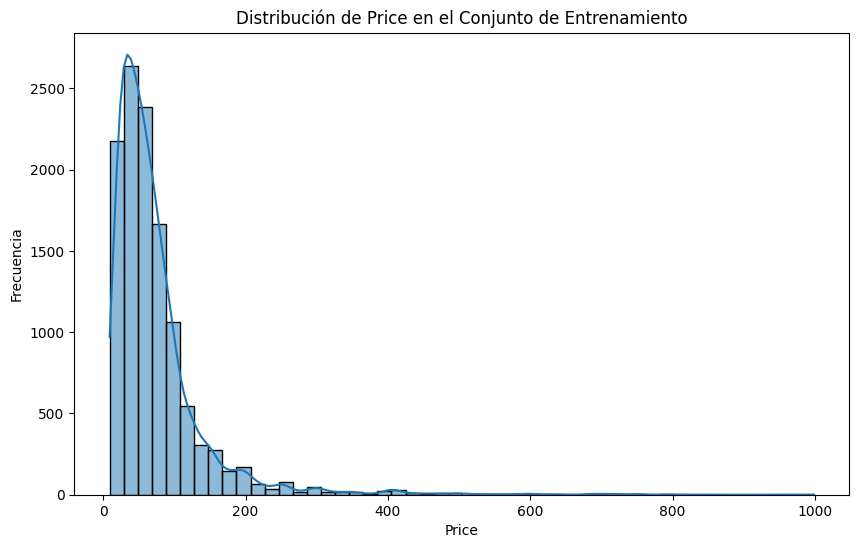

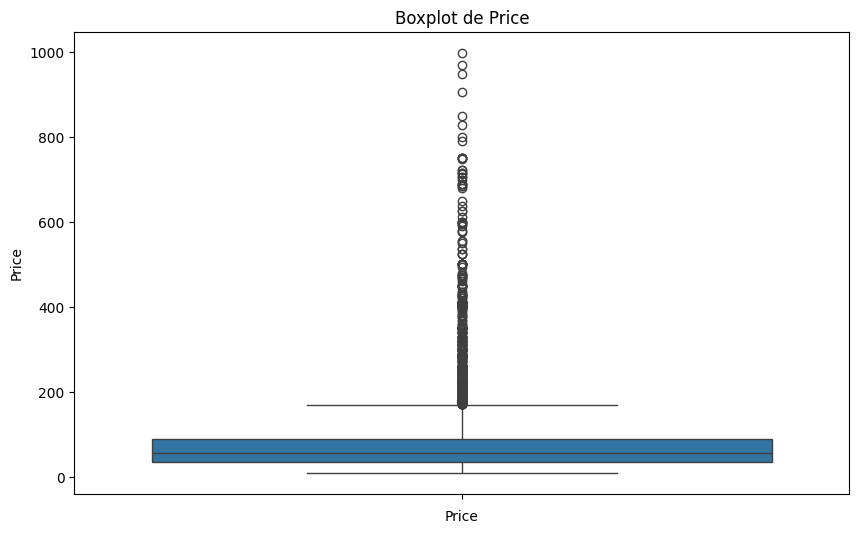

In [3]:
import seaborn as sns

# Análisis de la distribución de la variable objetivo 'Price'
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribución de Price en el Conjunto de Entrenamiento')
plt.xlabel('Price')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot para identificar valores atípicos
plt.figure(figsize=(10, 6))
sns.boxplot(y_train)
plt.title('Boxplot de Price')
plt.xlabel('Price')
plt.show()


In [4]:
# Porcentaje de valores faltantes por columna en el conjunto de entrenamiento
missing_values = X_train.isnull().mean() * 100
missing_values[missing_values > 0].sort_values(ascending=False)


Has Availability                  99.923884
Host Acceptance Rate              99.737821
Jurisdiction Names                98.486130
License                           97.589648
Square Feet                       95.991204
Monthly Price                     75.862652
Weekly Price                      75.685047
Notes                             61.907984
Security Deposit                  57.907645
Interaction                       44.392760
Access                            43.834574
Cleaning Fee                      41.864005
Transit                           38.937754
Neighborhood Overview             38.540257
Neighbourhood                     35.740866
Host About                        35.554804
House Rules                       34.852842
Space                             26.522327
Host Neighbourhood                26.412382
Review Scores Value               22.775710
Review Scores Location            22.767253
Review Scores Checkin             22.733424
Review Scores Accuracy          

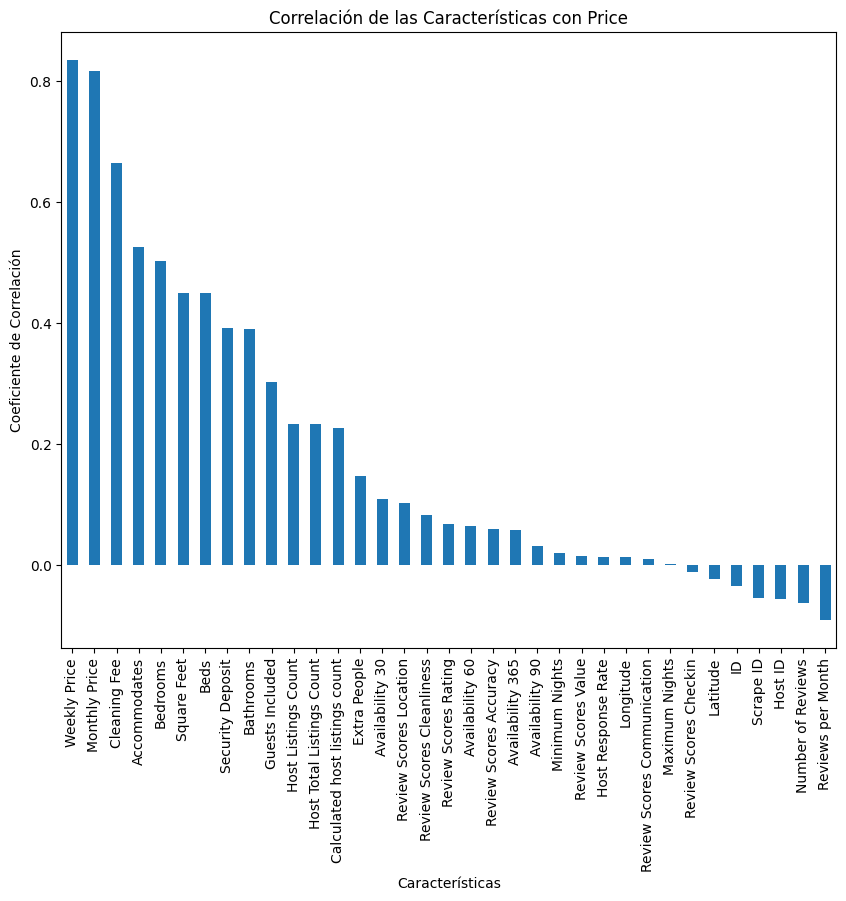

In [5]:
# Análisis de correlación entre características numéricas y la variable objetivo
# Reinsertamos temporalmente 'Price' en el conjunto de entrenamiento para cálculos de correlación
train_data_with_target = X_train.copy()
train_data_with_target['Price'] = y_train

# Seleccionando solo columnas numéricas para el cálculo de la correlación
numerical_data = train_data_with_target.select_dtypes(include=['int64', 'float64'])

# Calculando la matriz de correlación para las columnas numéricas
correlation_matrix = numerical_data.corr()

# Extraer las correlaciones específicas con 'Price'
correlations_with_price = correlation_matrix['Price'].sort_values(ascending=False)

# Visualizar las correlaciones con 'Price'
plt.figure(figsize=(10, 8))
correlations_with_price.drop('Price').plot(kind='bar')
plt.title('Correlación de las Características con Price')
plt.xlabel('Características')
plt.ylabel('Coeficiente de Correlación')
plt.show()

## 3. Preprocesamiento
a. Eliminación de variables.

In [6]:
# Importar librerías necesarias para el preprocesamiento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Identificar columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Crear transformadores para el preprocesamiento
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combinar transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

# Modelo final
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Incorporar el preprocesador y el modelo en un pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', model)])


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import pandas as pd

# Eliminar filas donde 'Price' es NaN y columnas no numéricas o innecesarias al inicio
airbnb_data_clean = airbnb_data.dropna(subset=['Price']).select_dtypes(include=[np.number])

# División del conjunto de datos en características (X) y variable objetivo (y), excluyendo 'Price' directamente
X = airbnb_data_clean.drop(columns=['Price'])
y = airbnb_data_clean['Price']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar el modelo de Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Utilizar SelectFromModel para identificar características importantes
selector = SelectFromModel(rf, threshold='median', prefit=True)

# Obtener los nombres de las características seleccionadas
selected_features = X_train.columns[selector.get_support()]

# Aplicar la selección de características a X_train y X_test utilizando los nombres de las características
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("Características seleccionadas:")
print(selected_features)



Características seleccionadas:
Index(['ID', 'Scrape ID', 'Host ID', 'Latitude', 'Longitude', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Monthly Price', 'Security Deposit',
       'Cleaning Fee', 'Extra People', 'Minimum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Reviews per Month'],
      dtype='object')


In [8]:
# Obtener los índices de las características seleccionadas
selected_features_bool = selector.get_support()

# Obtener los nombres de las columnas de las características seleccionadas
selected_features_names = X_train.columns[selected_features_bool]

# Filtrar X_train y X_test para seleccionar solo las características importantes
X_train_selected = X_train[selected_features_names]
X_test_selected = X_test[selected_features_names]

# Mostrar las dimensiones resultantes para confirmar la selección
print(f"Dimensiones originales de X_train: {X_train.shape}")
print(f"Dimensiones después de la selección en X_train: {X_train_selected.shape}")
print(f"Dimensiones originales de X_test: {X_test.shape}")
print(f"Dimensiones después de la selección en X_test: {X_test_selected.shape}")



Dimensiones originales de X_train: (11810, 35)
Dimensiones después de la selección en X_train: (11810, 18)
Dimensiones originales de X_test: (2953, 35)
Dimensiones después de la selección en X_test: (2953, 18)


In [9]:
# Obtener la importancia de las características
feature_importances = rf.feature_importances_

# Crear un DataFrame para visualizar mejor la importancia de las características
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)


                           Feature  Importance
10                        Bedrooms    0.190034
9                        Bathrooms    0.139059
16                    Cleaning Fee    0.096173
2                          Host ID    0.070773
8                     Accommodates    0.067755
6                         Latitude    0.049547
7                        Longitude    0.037831
1                        Scrape ID    0.036440
22                 Availability 60    0.027909
14                   Monthly Price    0.027324
0                               ID    0.025200
23                 Availability 90    0.023923
24                Availability 365    0.022532
18                    Extra People    0.021116
21                 Availability 30    0.019857
15                Security Deposit    0.017523
19                  Minimum Nights    0.014569
34               Reviews per Month    0.014088
13                    Weekly Price    0.013584
3               Host Response Rate    0.013560
11           

b. Generación de variables.

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Ejemplo con un grado polinómico de 2
poly = PolynomialFeatures(degree=2, include_bias=False)

# Hacemos solo 'Latitude' y 'Longitude'
X_poly = poly.fit_transform(X_train[['Latitude', 'Longitude']])

# Convertir a DataFrame para una mejor interpretación
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(['Latitude', 'Longitude']), index=X_train.index)

# Unir las nuevas variables polinómicas al conjunto de entrenamiento original
X_train_enriched = pd.concat([X_train, X_poly_df], axis=1)


In [11]:
# Crear una interacción entre 'Accommodates' y 'Bathrooms'
X_train['Accommodates_Bathrooms'] = X_train['Accommodates'] * X_train['Bathrooms']


In [12]:
# Categorizar 'Reviews per Month' en rangos
X_train['Reviews_per_Month_bin'] = pd.cut(X_train['Reviews per Month'], bins=3, labels=['Low', 'Medium', 'High'])


## 4. Modelado
a. Cross validation.

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

# Identifica columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Crea transformadores para el preprocesamiento
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combinar transformadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

# Incorporar el preprocesador en un pipeline con el modelo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', LinearRegression())])


In [14]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada
scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir a RMSE
rmse_scores = np.sqrt(-scores)

print("RMSE scores:", rmse_scores)
print("Media RMSE:", rmse_scores.mean())

RMSE scores: [49.73545725 50.62392934 51.25913591 49.68038544 53.57066736]
Media RMSE: 50.97391505889567


b. Evaluación

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Definir los modelos a comparar
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42)
}


In [16]:
# Asegúrate de que el preprocesamiento esté incluido en este paso si es necesario

# Diccionario para guardar los resultados de RMSE
rmse_results = {}

for name, model in models.items():
    # Incorporar el preprocesador en un pipeline con el modelo (si preprocesamiento es necesario)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Realizar validación cruzada
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    # Calcular RMSE y almacenar los resultados
    rmse_scores = np.sqrt(-cv_scores)
    rmse_results[name] = rmse_scores
    
    print(f"{name}: Media RMSE = {np.mean(rmse_scores):.3f}, Desviación Estándar = {np.std(rmse_scores):.3f}")


LinearRegression: Media RMSE = 50.974, Desviación Estándar = 1.425
DecisionTreeRegressor: Media RMSE = 58.078, Desviación Estándar = 3.281
RandomForestRegressor: Media RMSE = 41.443, Desviación Estándar = 1.838


## 5. Conclusión



La regresión lineal muestra un rendimiento relativamente moderado con un error promedio de casi 51. La desviación estándar relativamente baja indica que el rendimiento del modelo es bastante consistente a través de diferentes particiones del conjunto de datos. 
En el caso del árbol de decisión, tiene el rendimiento más bajo de los tres modelos, con el RMSE medio más alto. Además, presenta la mayor variabilidad en su rendimiento, como lo indica su desviación estándar más alta. Esto puede sugerir que el modelo es más sensible a las variaciones en los datos de entrenamiento. 
Por último el modelo de random forest ofrece el mejor rendimiento de los tres, con el RMSE medio más bajo, indicando que, en promedio, sus predicciones están más cerca de los valores reales. Aunque su desviación estándar es ligeramente superior a la de la regresión lineal, sigue siendo razonablemente baja, lo que sugiere que el modelo es relativamente estable a través de diferentes conjuntos de datos de validación cruzada. 